# Photosynthesis

Understanding photosynthesis through code.

In [3]:
import numpy as np
import matplotlib.pyplot as plt

## Defining input variables

Sidenote: why is there no easy way to keep track of units in python? Like m/s, umol/m^2/s, and so on?

Units should be part of the datatype. Looks like `astropy` is one library that supports this.

In [4]:
from typing import Tuple
def quadratic(a: float, b: float, c: float) -> Tuple[float, float]:
    """
    Finds the smaller root of a quadratic equation of the form ax^2 + bx + c = 0.

    :param a: Coefficient of x^2
    :param b: Coefficient of x
    :param c: Constant term
    :return: Smaller root of the quadratic equation
    """
    discriminant = b**2 - 4*a*c
    if discriminant < 0:
        raise ValueError("Quadratic equation has no real roots")
    elif discriminant == 0:
        return -b / (2*a), -b / (2*a)
    else:
        root1 = (-b - discriminant**0.5) / (2*a)
        root2 = (-b + discriminant**0.5) / (2*a)
        return root1, root2

In [5]:
def smaller_root(a, b, c):
    r1, r2 = quadratic(a, b, c)
    return min(r1, r2)

In [6]:
# Electron transport rate
# par = photosynthetically active radiation (W / m^2)

def electron_transport_rate(par_z: float):
    theta_psii = 0.7 # curve fitting parameter
    phi_psii = 0.85 # quantum yield of PSII
    J_max = 200 # (sus) from ChatGPT in umol electron / m^2 / s
    
    I_psii = 0.5 * phi_psii * 4.6 * par_z

    a = theta_psii
    b = - (I_psii + J_max)
    c = I_psii * J_max
    r = smaller_root(a, b, c)

    return r

    

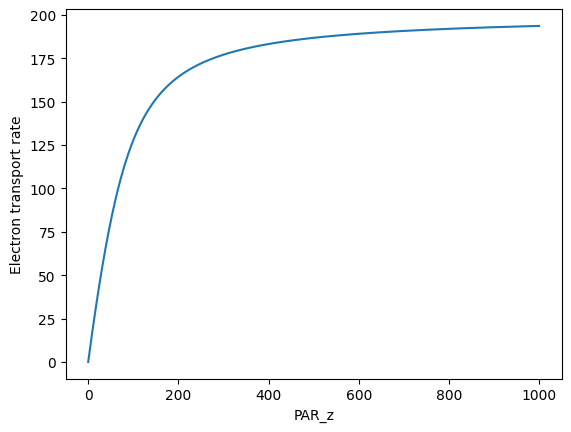

In [62]:
x = np.linspace(0, 1000, 1000)
y = [electron_transport_rate(par_z) for par_z in x]

# Plot the data
plt.plot(x, y)
plt.xlabel('PAR_z')
plt.ylabel('Electron transport rate')
plt.show()

In [104]:
# These variables are all constants

boundary_conductance = 500 
c_air = 40 
o_air = 21000
leaf_maintenance_respiration = 3
par_z = 500
relative_humidity = 0.40

p_atm = 121000

co2_compensation_point = 100 # (check back on this)
kc = 25 # (definitely check back on these)
ko = 10000

medlynslope = 6
medlynintercept = 100

vcmax = 50 # maximum rate of carboxylation (umol / m^2 / s)

tpu_z = 0.167 * vcmax # Triose phosphate utilization rate is based on carboxylation rate

# Co-limiting parameters
theta_cj = 0.98
theta_ip = 0.95


## Internal partial pressure of CO2

In [105]:
def co_limit(A_c: float, A_j: float, A_p: float, theta_cj: float, theta_ip: float) -> float:
    A_tot = smaller_root(theta_cj, -(A_c + A_j), A_c * A_j)
    A_tot = smaller_root(theta_ip, -(A_tot + A_p), A_tot * A_p)
    return A_tot

In [106]:
def ci_func(ci, je):
    # Calculate A_c, A_j, A_p (assuming C3)
    # A_c = 2000
    # NOTE: I removed the subtraction of the co2 compensation point from ci
    A_c = vcmax * ci  / (ci + kc * (1 + o_air / ko))
    A_j = je * ci  / (4 * ci + 8 * co2_compensation_point)
    A_p = 3 * tpu_z

    # print(f"A_c: {A_c} umol CO2 /m^2/s")
    # print(f"A_j: {A_j} umol CO2 /m^2/s")
    # print(f"A_p: {A_p} umol CO2 /m^2/s")



    # Colimit these values for gross photosynthesis
    A_g = co_limit(A_c, A_j, A_p, theta_cj, theta_ip)    
    # print(f"Gross photosynthesis: {A_g} umol CO2 /m^2/s")

    # Subtract lmr to get to net photosynthesis (TODO: subtract lmr)
    A_n = A_g - leaf_maintenance_respiration
    # A_n = A_g - leaf_maintenance_respiration
    # print(f"Net photosynthesis: {A_n} umol CO2 /m^2/s")

    # if (A_n < 0):
    #     return 0, 0, 0


    # Calculate stomatal conductance (gs_mol):
    c_surface = c_air - 1.4 / boundary_conductance * A_n * p_atm
    term = 1.6 * A_n / (c_surface / p_atm * 1e6)
    a = 1.0
    b = - (2.0 * (medlynintercept * 1e-6 + term) + (medlynslope * term) ** 2 / (boundary_conductance * 1e-6 * relative_humidity))
    c = medlynintercept**2 * 1e-12 + (2.0 * medlynintercept * 1e-6 + term * (1.0 - medlynslope**2 / relative_humidity)) * term
    r1, r2 = quadratic(a, b, c)
    gs_mol = max(r1, r2) * 1e6


    # Derive new estimate for ci
    new_ci = c_air - (1.4 / boundary_conductance + 1.6 / gs_mol) * p_atm * A_n
    fval = ci - new_ci
    # print(f"fval: {fval} umol CO2 /m^2/s")
    # print(f"ci: {ci} umol CO2 /m^2/s")

    return A_n, gs_mol, fval
    

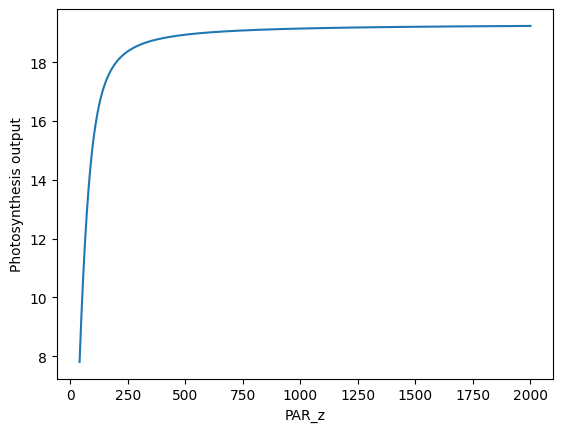

In [107]:
# Fix CI and change par_z

ci = 400

def photosynthesis_output(par_z: float):
    je = electron_transport_rate(par_z)

    # TODO: Given je, find optimal ci by rootfinding.

    return ci_func(ci, je)[0]

# Graph a light response curve
x = np.linspace(40, 2000, 1000)
y = [photosynthesis_output(par_z) for par_z in x]

plt.plot(x, y)
plt.xlabel('PAR_z')
plt.ylabel('Photosynthesis output')
plt.show()

ci: 14.406350491536477


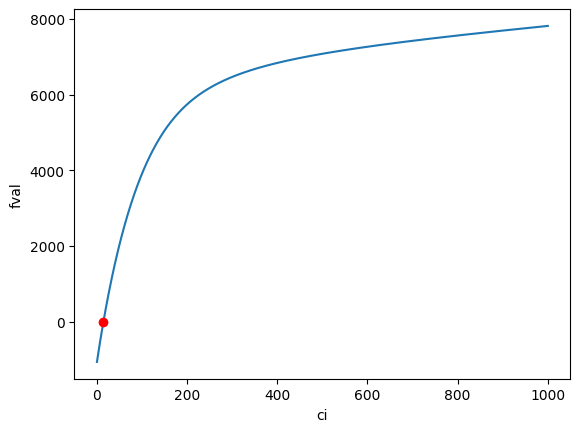

In [108]:
# Fix PAR_z and find optimal ci
par_z = 500
je = electron_transport_rate(par_z)

# Use scipy to find the root of ci_func
from scipy.optimize import root_scalar
import functools

o2_compensation_point = 50 # initial guess for the root

f = functools.partial(ci_func, je=je)
g = lambda x: f(x)[2]
sol = root_scalar(g, bracket=[0, 1000], method='brentq')

ci = sol.root

# Graph fval vs ci
x = np.linspace(0, 1000, 1000)
y = [g(ci) for ci in x]

plt.plot(x, y)
plt.xlabel('ci')
plt.ylabel('fval')
plt.plot(ci, 0, 'ro')
print(f"ci: {ci}")
plt.show()


In [133]:
# These variables are all constants

boundary_conductance = 500
c_air = 40 
o_air = 21000
leaf_maintenance_respiration = 6
relative_humidity = 0.40

p_atm = 121000

co2_compensation_point = 4 # (check back on this)
kc = 25 # (definitely check back on these)
ko = 10000

medlynslope = 6
medlynintercept = 100

vcmax = 50 # maximum rate of carboxylation (umol / m^2 / s)

tpu_z = 0.167 * vcmax # Triose phosphate utilization rate is based on carboxylation rate

# Co-limiting parameters
theta_cj = 0.98
theta_ip = 0.95

def ci_func(ci, je):
    # Calculate A_c, A_j, A_p (assuming C3)
    # A_c = 2000
    # NOTE: I removed the subtraction of the co2 compensation point from ci
    A_c = vcmax * max(ci - co2_compensation_point, 0)  / (ci + kc * (1 + o_air / ko))
    A_j = je * max(ci - co2_compensation_point, 0)  / (4 * ci + 8 * co2_compensation_point)
    A_p = 3 * tpu_z

    print(f"A_c: {A_c} umol CO2 /m^2/s")
    print(f"A_j: {A_j} umol CO2 /m^2/s")
    print(f"A_p: {A_p} umol CO2 /m^2/s")



    # Colimit these values for gross photosynthesis
    A_g = co_limit(A_c, A_j, A_p, theta_cj, theta_ip)    
    # print(f"Gross photosynthesis: {A_g} umol CO2 /m^2/s")

    # Subtract lmr to get to net photosynthesis (TODO: subtract lmr)
    A_n = A_g - leaf_maintenance_respiration
    # A_n = A_g - leaf_maintenance_respiration
    print(f"Net photosynthesis: {A_n} umol CO2 /m^2/s")

    # if (A_n < 0):
    #     return 0, 0, 0


    # Calculate stomatal conductance (gs_mol):
    c_surface = c_air - 1.4 / boundary_conductance * A_n * p_atm
    term = 1.6 * A_n / (c_surface / p_atm * 1e6)
    a = 1.0
    b = - (2.0 * (medlynintercept * 1e-6 + term) + (medlynslope * term) ** 2 / (boundary_conductance * 1e-6 * relative_humidity))
    c = medlynintercept**2 * 1e-12 + (2.0 * medlynintercept * 1e-6 + term * (1.0 - medlynslope**2 / relative_humidity)) * term
    r1, r2 = quadratic(a, b, c)
    gs_mol = max(r1, r2) * 1e6
    print(f"Stomatal conductance: {gs_mol} mol H2O /m^2/s")


    # Derive new estimate for ci
    print(1.4 / boundary_conductance + 1.6 / gs_mol)
    print(p_atm)
    print((1.4 / boundary_conductance + 1.6 / gs_mol) * p_atm )
    new_ci = c_air - (1.4 / boundary_conductance + 1.6 / gs_mol) * p_atm * A_n
    fval = ci - new_ci
    # print(f"fval: {fval} umol CO2 /m^2/s")
    # print(f"ci: {ci} umol CO2 /m^2/s")

    return A_n, gs_mol, fval


# Use scipy to find the root of ci_func
from scipy.optimize import root_scalar
import functools

# Function to find optimal ci given par_z
def optimal_ci(par_z: float) -> float:
    je = electron_transport_rate(par_z)

    f = functools.partial(ci_func, je=je)
    g = lambda x: f(x)[2]
    sol = root_scalar(g, bracket=[0, 1000], method='brentq')

    ci = sol.root

    return ci
    

A_c: 0.0 umol CO2 /m^2/s
A_j: 0.0 umol CO2 /m^2/s
A_p: 25.049999999999997 umol CO2 /m^2/s
Net photosynthesis: -6.0 umol CO2 /m^2/s
Stomatal conductance: 56108.11862955158 mol H2O /m^2/s
0.0028285163723019095
121000
342.25048104853107
A_c: 46.21809744779582 umol CO2 /m^2/s
A_j: 16.74259177506648 umol CO2 /m^2/s
A_p: 25.049999999999997 umol CO2 /m^2/s
Net photosynthesis: 9.34468371876053 umol CO2 /m^2/s
Stomatal conductance: 59831.82723517297 mol H2O /m^2/s
0.002826741620203426
121000
342.03573604461457
A_c: 40.120626316791466 umol CO2 /m^2/s
A_j: 16.351463632558414 umol CO2 /m^2/s
A_p: 25.049999999999997 umol CO2 /m^2/s
Net photosynthesis: 9.011898014863492 umol CO2 /m^2/s
Stomatal conductance: 59888.29674620569 mol H2O /m^2/s
0.0028267164051564275
121000
342.03268502392774
A_c: 30.18801737938287 umol CO2 /m^2/s
A_j: 15.451239289798366 umol CO2 /m^2/s
A_p: 25.049999999999997 umol CO2 /m^2/s
Net photosynthesis: 8.213966925459111 umol CO2 /m^2/s
Stomatal conductance: 60042.74345584102 mol

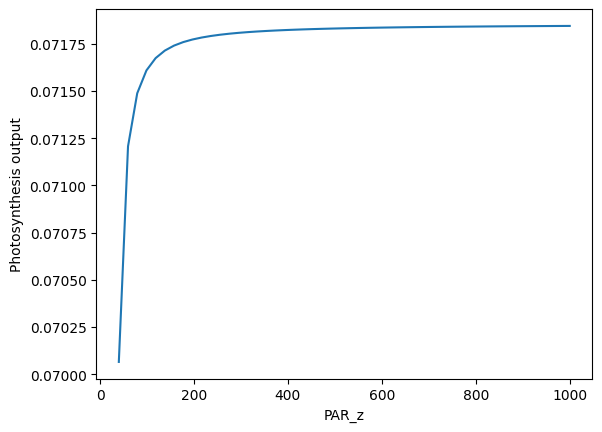

In [134]:
def photosynthesis_output(par_z: float):
    ci = optimal_ci(par_z)
    je = electron_transport_rate(par_z)
    print(f"-----ci: {ci}, je: {je}")

    return ci_func(ci, je)[0]

# Graph a light response curve
x = np.linspace(40, 1000, 50)
y = [photosynthesis_output(par_z) for par_z in x]

plt.plot(x, y)
plt.xlabel('PAR_z')
plt.ylabel('Photosynthesis output')
plt.show()
